In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, "..")
from stamp import *
from physics import *
from astropy.stats import sigma_clipped_stats
import re
import os
%load_ext autoreload
%autoreload 2

matplotlib.style.use('paper')


table_outflow = Table.read("../outflow_hops.csv", comment='#')
table_outflow_davis = Table.read("../outflow_davisnohops.csv", comment='#')
table_hops = Table.read("../../catalogs/hops.fits")
table_davis = Table.read("../../catalogs/davis09_jets_without_hops.txt", format='ascii.tab')
outflow_def = table_outflow[table_outflow['outflow'] == '1']
outflow_may = table_outflow[table_outflow['outflow'] == '?']
outflow_hops = table_outflow[(table_outflow['outflow'] == '1') | (table_outflow['outflow'] == '?')]
outflow_davis = table_outflow_davis[(table_outflow_davis['outflow'] == '1') | (table_outflow_davis['outflow'] == '?')]

c12 = SpectralCube.read("../../cubes/mask_imfit_12co_pix_2_Tmb.fits")
c13 = SpectralCube.read("../../cubes/mask_imfit_13co_pix_2_Tmb_regrid12co.fits")
c18 = SpectralCube.read("../../cubes/mask_imfit_c18o_pix_2_Tmb.fits")

c12.allow_huge_operations = True
c12_peak = c12.max((0))


roll_n1n1_davisn = [17,30,50]
roll_n1n1_hopsn = [12, 50, 68, 70, 81, 84, 88, 96, 157, 160, 192, 198, 203, 355, 368, 383]

In [2]:
# c12_mom0 = c12.moment0()

In [3]:
# c18.allow_huge_operations = True
# c18_peak = c18.max((0))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


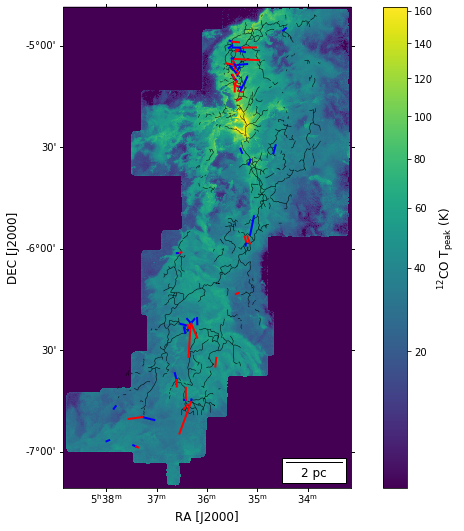

In [17]:
from matplotlib.colors import LogNorm
from matplotlib import cm

from astropy.visualization.mpl_normalize import simple_norm
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)


fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1, projection=c12.wcs.celestial)

image_peak = c12_peak.data
# image_mom0 = c12_mom0.data
# Create an ImageNormalize object
# norm_mom0 = ImageNormalize(image_mom0, interval=MinMaxInterval(),
#                       stretch=SqrtStretch())
norm_peak = ImageNormalize(image_peak, interval=MinMaxInterval(),
                      stretch=SqrtStretch())
norm = simple_norm(image_peak, stretch='sqrt', min_percent=1, max_percent=99.9)

# cmap = cm.Greys
cmap = cm.viridis
# cmap.set_bad(color='white')
print(np.nan_to_num(np.array(image_peak)))
im = ax.imshow(np.nan_to_num(np.array(image_peak)), origin='lower', cmap=cmap, norm=norm, interpolation='none')
# ax.imshow(image_mom0,origin='lower', cmap=cm.gray_r, norm=norm_mom0, interpolation='none')



lon, lat = ax.coords[0], ax.coords[1]



ax.tick_params(labelsize='medium')
ax.set_xlabel("RA [J2000]")
ax.set_ylabel("DEC [J2000]")
lon.set_ticks(exclude_overlapping=True, number=5)

files = glob.glob("../../filaments/filaments_wcs/*.txt")

show_filaments=1
if show_filaments:
    for file in files:
        t = ascii.read(file, names=['ra','dec','v'])
        ra,dec,v = t['ra'].data, t['dec'].data, t['v'].data


        if len(ra) >= 15: 
            ax.plot(ra,dec,transform=ax.get_transform('world'),
                   lw=0.5, color='black', alpha=1, zorder=2)
show_scalebar=True
if show_scalebar:
    pc2pix = lambda x: x * 206265 / dist.value / 2
    ob = AnchoredHScaleBar(size=pc2pix(2.), label="{} pc".format(2), loc='lower right', frameon=True,
                           pad=0.4,sep=4,extent=0,color="black", textprops=dict(size=12), lw=1, ax=ax) 
    ax.add_artist(ob)


pc_to_deg = lambda x: (206265./3600)*(x/414.)
    
table_outflow_physics = ascii.read("../physics_outflows.txt")

for row in table_outflow_physics:
    if row['lobe'] == 'B':
        color = 'blue'
    if row['lobe'] == 'R':
        color = 'red'
    pa = row['pa']
    ra = row['RAJ2000']
    dec = row['DEJ2000']
    conf = row['confidence']
    rmax = row['rmax']
    
    dx_pc = rmax * np.sin(pa * np.pi/180.)
    dx_deg = pc_to_deg(dx_pc)
    dy_pc = rmax * np.cos(pa * np.pi/180.)
    dy_deg = pc_to_deg(dy_pc)

    ax.plot([ra, ra+dx_deg],
             [dec, dec+dy_deg],
            lw=2, color=color, ls='-',
            transform=ax.get_transform('world'), zorder=3)
#             print(np.roll(slab_blue.with_mask(mask_blue).moment0().data,
#                         (-1,-1), axis=(0,1)))
    
cb = fig.colorbar(im, label=r"$^{12}$CO T$_{\rm peak}$ (K)")   
cb.ax.tick_params(labelsize='medium') 
fig.tight_layout()
fig.savefig("../../paper/overview.pdf", bbox_inches='tight')
    # print(files)

[[85.42547  85.203964 83.45251  ... 72.15941  71.987495 71.45273 ]
 [85.336624 84.6564   82.56803  ... 72.281525 72.38047  72.11351 ]
 [84.36469  83.288376 80.99944  ... 72.215256 72.3462   72.42675 ]
 ...
 [84.96088  84.19798  83.687775 ... 69.84063  69.381775 70.100494]
 [85.22006  85.787285 86.39732  ... 70.18284  70.94731  71.72893 ]
 [83.819695 85.22793  86.829346 ... 71.09851  72.66661  73.398865]]


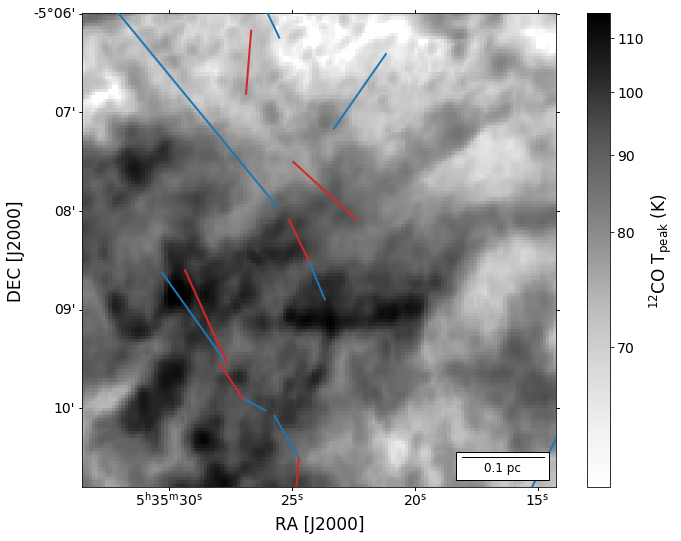

In [25]:
matplotlib.style.use('paper')
c12 = extract_subcube(c12, RectangleSkyRegion,
            region_kwargs=dict(center=SkyCoord.from_name("hops 68"),
                               width=5*u.arcmin, height=5*u.arcmin))
c12.allow_huge_operations = True
c12_peak = c12.max((0))


roll_n1n1_davisn = [17,30,50]
roll_n1n1_hopsn = [12, 50, 68, 70, 81, 84, 88, 96, 157, 160, 192, 198, 203, 355, 368, 383]
from matplotlib.colors import LogNorm
from matplotlib import cm

from astropy.visualization.mpl_normalize import simple_norm
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)


fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1, projection=c12.wcs.celestial)

image_peak = c12_peak.data
# image_mom0 = c12_mom0.data
# Create an ImageNormalize object
# norm_mom0 = ImageNormalize(image_mom0, interval=MinMaxInterval(),
#                       stretch=SqrtStretch())
norm_peak = ImageNormalize(image_peak, interval=MinMaxInterval(),
                      stretch=SqrtStretch())
norm = simple_norm(image_peak, stretch='sqrt', min_percent=1, max_percent=99.9)

cmap = cm.Greys
# cmap.set_bad(color='white')
print(np.nan_to_num(np.array(image_peak)))
im = ax.imshow(np.nan_to_num(np.array(image_peak)), origin='lower', cmap=cmap, norm=norm, interpolation='none')
# ax.imshow(image_mom0,origin='lower', cmap=cm.gray_r, norm=norm_mom0, interpolation='none')



lon, lat = ax.coords[0], ax.coords[1]



ax.tick_params(labelsize='medium')
ax.set_xlabel("RA [J2000]")
ax.set_ylabel("DEC [J2000]")
lon.set_ticks(exclude_overlapping=True, number=5)

files = glob.glob("../../filaments/filaments_wcs/*.txt")

show_filaments=0
if show_filaments:
    for file in files:
        t = ascii.read(file, names=['ra','dec','v'])
        ra,dec,v = t['ra'].data, t['dec'].data, t['v'].data


        if len(ra) >= 15: 
            ax.plot(ra,dec,transform=ax.get_transform('world'),
                   lw=0.5, color='lime', alpha=1, zorder=2)
show_scalebar=True
if show_scalebar:
    pc2pix = lambda x: x * 206265 / dist.value / 2
    ob = AnchoredHScaleBar(size=pc2pix(0.1), label="{} pc".format(0.1), loc='lower right', frameon=True,
                           pad=0.4,sep=4,extent=0,color="black", textprops=dict(size=12), lw=1, ax=ax) 
    ax.add_artist(ob)


pc_to_deg = lambda x: (206265./3600)*(x/414.)
    
table_outflow_physics = ascii.read("../physics_outflows.txt")

for row in table_outflow_physics:
    if row['lobe'] == 'B':
        color = 'tab:blue'
    if row['lobe'] == 'R':
        color = 'tab:red'
    pa = row['pa']
    ra = row['RAJ2000']
    dec = row['DEJ2000']
    conf = row['confidence']
    rmax = row['rmax']
    
    dx_pc = rmax * np.sin(pa * np.pi/180.)
    dx_deg = pc_to_deg(dx_pc)
    dy_pc = rmax * np.cos(pa * np.pi/180.)
    dy_deg = pc_to_deg(dy_pc)

    ax.autoscale(enable=False)
    ax.plot([ra, ra+dx_deg],
             [dec, dec+dy_deg],
            lw=2, color=color, ls='-',
            transform=ax.get_transform('world'), zorder=3)
#             print(np.roll(slab_blue.with_mask(mask_blue).moment0().data,
#                         (-1,-1), axis=(0,1)))
    
cb = fig.colorbar(im, label=r"$^{12}$CO T$_{\rm peak}$ (K)")   
cb.ax.tick_params(labelsize='medium') 
fig.tight_layout()
fig.savefig("../../paper/overview_nofils_5arcmin.pdf", bbox_inches='tight')
    # print(files)